# 準備

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

#モデル
import lightgbm as lgb

#パラメータ探索
import optuna

#クロスバリデーション
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold

#エヴァリュエーション
from sklearn.metrics import precision_score, recall_score, mean_squared_error

#可視化
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report

#保存
import pickle

In [2]:
#データを読み込む
n_uma_race_df = pd.read_pickle('../datasets/traindata/n_uma_race.pkl')
n_race_df = pd.read_pickle('../datasets/traindata/n_race.pkl')
n_payout_df = pd.read_pickle('../datasets/traindata/n_payout.pkl')

In [3]:
# 新しいグループを作成
n_uma_race_df['group'] = n_uma_race_df['kaisai_nen'].astype(int).astype(str) +"-"+ n_uma_race_df['kaisai_tsukihi'].astype(int).astype(str) +"-"+  n_uma_race_df['keibajo_code'].astype(int).astype(str) +"-"+  n_uma_race_df['race_bango'].astype(int).astype(str)
n_race_df['group'] = n_race_df['kaisai_nen'].astype(int).astype(str) +"-"+ n_race_df['kaisai_tsukihi'].astype(int).astype(str) +"-"+  n_race_df['keibajo_code'].astype(int).astype(str) +"-"+  n_race_df['race_bango'].astype(int).astype(str)
n_payout_df['group'] = n_payout_df['kaisai_nen'].astype(int).astype(str) +"-"+ n_payout_df['kaisai_tsukihi'].astype(int).astype(str) +"-"+  n_payout_df['keibajo_code'].astype(int).astype(str) +"-"+  n_payout_df['race_bango'].astype(int).astype(str)

n_race_df = n_race_df.drop(['kaisai_nen', 'kaisai_tsukihi', 'keibajo_code', 'kaisai_kai', 'kaisai_nichime', 'race_bango'],axis=1)
n_payout_df = n_payout_df.drop(['kaisai_nen', 'kaisai_tsukihi', 'keibajo_code', 'kaisai_kai', 'kaisai_nichime', 'race_bango', 'toroku_tosu', 'shusso_tosu'],axis=1)

merged_df = pd.merge(n_uma_race_df, n_race_df, on='group', how='left')
merged_df = pd.merge(merged_df, n_payout_df, on='group', how='left')
merged_df['group'].nunique()

205318

In [4]:
merged_df['group'].unique()

array(['2023-916-46-1', '2023-916-46-2', '2023-916-46-3', ...,
       '2023-907-50-10', '2023-907-50-11', '2023-907-50-12'], dtype=object)

In [5]:
pd.set_option('display.max_columns', None)
merged_df.head(1)

,kaisai_nen,kaisai_tsukihi,keibajo_code,kaisai_kai,kaisai_nichime,race_bango,wakuban,umaban,ketto_toroku_bango,bamei,umakigo_code,seibetsu_code,hinshu_code,moshoku_code,barei,tozai_shozoku_code,chokyoshi_code,banushi_code,banushimei,futan_juryo,blinker_shiyo_kubun,kishu_code,kishumei_ryakusho,kishu_minarai_code,bataiju,zogen_fugo,zogen_sa,ijo_kubun_code,nyusen_juni,kakutei_chakujun,dochaku_kubun,dochaku_tosu,soha_time,chakusa_code_1,chakusa_code_2,chakusa_code_3,corner_1,corner_2,corner_3,corner_4,tansho_odds,tansho_ninkijun,kakutoku_honshokin,kakutoku_fukashokin,kohan_4f,kohan_3f,aiteuma_joho_1,aiteuma_joho_2,aiteuma_joho_3,time_sa,record_koshin_kubun,kyakushitsu_hantei,group,yobi_code,jusho_kaiji,grade_code,kyoso_shubetsu_code,kyoso_kigo_code,juryo_shubetsu_code,kyoso_joken_code_2sai,kyoso_joken_code_3sai,kyoso_joken_code_4sai,kyoso_joken_code_5sai_ijo,kyoso_joken_code,kyori,track_code,course_kubun,honshokin,fukashokin,hasso_jikoku,toroku_tosu,shusso_tosu,nyusen_tosu,tenko_code,babajotai_code_shiba,babajotai_code_dirt,fuseiritsu_flag_sanrenpuku,tokubarai_flag_sanrenpuku,henkan_flag_sanrenpuku,haraimodoshi_sanrenpuku_1a,haraimodoshi_sanrenpuku_1b,haraimodoshi_sanrenpuku_1c
0,2023,916,46,13,1,1,1,1,2020106227,スターサファイア,0,1,1.0,3,3,3,5319,875800,ＪＰＮ技研,560.0,0,5300,葛山晃平,0,466.0,1,0.0,0,8,8,0,0,1359,4.0,NaN,NaN,9,9,9,9,899,8,0,0,0,411,2020105068フェイマスグローリ,0000000000,0000000000,50,0,0,2023-916-46-1,1,0,0,49,0,4,0,0,0,0,0,1400,24,0,4.000000e+51,0,1140,9,9,9,1,0,1.0,0.0,0.0,0.0,60809.0,210.0,1.0


# 前処理

In [6]:
merged_df['hutan_wariai'] = merged_df['futan_juryo'] / merged_df['bataiju']

In [7]:
def combine_sign_and_diff(row):
    if row['zogen_fugo'] == 2:
        return row['zogen_sa']
    elif row['zogen_fugo'] == 0:
        return -row['zogen_sa']
    else:
        return 0

merged_df['zogen_ryou'] = merged_df.apply(combine_sign_and_diff, axis=1)

In [8]:
merged_df = merged_df[merged_df['ijo_kubun_code'] == 0]
# 1	出走取消	取消	SCRATCHED	S

In [9]:
columns_to_convert = [
                    'kyori',
                    'grade_code',
                    'seibetsu_code',
                    'moshoku_code',
                    'barei',
                    'chokyoshi_code',
                    'banushi_code',
                    'kishu_code',
                    'kishu_minarai_code',
                    'kyoso_shubetsu_code',
                    'juryo_shubetsu_code',
                    'shusso_tosu',
                    'tenko_code',
                    'babajotai_code_dirt',
                    'hutan_wariai',
                    'zogen_ryou',
                    'track_code',
                    'keibajo_code'
                    ]

for column in columns_to_convert:
    merged_df[column].fillna(0, inplace=True)
    try:
        if merged_df[column].astype(float).apply(lambda x: x.is_integer()).all():
            merged_df[column] = merged_df[column].astype(int)
        else:
            merged_df[column] = merged_df[column].astype(float)
    except ValueError:
        merged_df[column] = merged_df[column].astype(float)

    print(f"{column} のデータ型: {merged_df[column].dtype}")

kyori のデータ型: int32
grade_code のデータ型: int32
seibetsu_code のデータ型: int32
moshoku_code のデータ型: int32
barei のデータ型: int32
chokyoshi_code のデータ型: int32
banushi_code のデータ型: int32
kishu_code のデータ型: int32
kishu_minarai_code のデータ型: int32
kyoso_shubetsu_code のデータ型: int32
juryo_shubetsu_code のデータ型: int32
shusso_tosu のデータ型: int32
tenko_code のデータ型: int32
babajotai_code_dirt のデータ型: int32
hutan_wariai のデータ型: float64
zogen_ryou のデータ型: int32
track_code のデータ型: int32
keibajo_code のデータ型: int32


In [10]:
merged_df[column].info()

<class 'pandas.core.series.Series'>
Index: 2017402 entries, 0 to 2042540
Series name: keibajo_code
Non-Null Count    Dtype
--------------    -----
2017402 non-null  int32
dtypes: int32(1)
memory usage: 23.1 MB


# lightgbm.LGBMRanker

In [11]:
# 2010年から2019年のデータを学習データとして取得
train_data = merged_df[merged_df['kaisai_nen'].isin([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]

In [12]:
# ランキング学習のために必要な特徴量とターゲットを設定
features = [
            # 'kyori',
            # 'grade_code',
            'seibetsu_code',
            'moshoku_code',
            'barei',
            'chokyoshi_code',
            'banushi_code',
            'kishu_code',
            'kishu_minarai_code',
            'kyoso_shubetsu_code',
            'juryo_shubetsu_code',
            # 'shusso_tosu',
            # 'tenko_code',
            # 'babajotai_code_dirt',
            'hutan_wariai',
            'zogen_ryou',
            # 'track_code',
            # 'keibajo_code'
            ]

target = 'kakutei_chakujun'

In [13]:
def ndcg_score(y_true, y_score, k=5):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    
    gain = 2 ** y_true - 1
    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

def mean_ndcg_score(y_true, y_score, groups, k=5):
    ndcgs = []
    idx_start = 0
    for group in groups:
        ndcgs.append(ndcg_score(y_true[idx_start:idx_start+group], y_score[idx_start:idx_start+group], k))
        idx_start += group
    return np.mean(ndcgs)

In [14]:
# def sigmoid(x):
#     return 1 / (1 + np.exp(-x))

# def lambda_rank_gradient(y_true, y_pred):
#     pred_diff = y_pred[:, None] - y_pred[None, :]
#     true_diff = y_true[:, None] - y_true[None, :]
    
#     S_ij = np.where(true_diff > 0, 1, np.where(true_diff < 0, -1, 0))
    
#     lambda_ij = 0.5 * (1 - S_ij) - sigmoid(-pred_diff)
    
#     grad = np.sum(lambda_ij, axis=1)
    
#     hess = np.sum(sigmoid(pred_diff) * (1 - sigmoid(pred_diff)), axis=1)
#     return grad, hess

In [15]:
# # 損失関数
# def custom_objective(y_true, y_pred):
#     grad, hess = lambda_rank_gradient(y_true, y_pred)
#     top5_indices = np.argsort(y_pred)[-5:]
#     if np.sum(y_true[top5_indices] == 1) == 0:
#         grad += penalty_grad
#         hess += penalty_hess
#     return grad, hess

# # サンプリング
# high_weight_value = 2.0
# sample_weights = np.where(train_data[target] == 1, high_weight_value, 1)

# # 再ランキング
# def rerank_predictions(y_pred):
#     top5_indices = np.argsort(y_pred)[-5:]
#     if np.sum(y_true[top5_indices] == 1) < 3:
#         one_indices = np.where(y_true == 1)[0]
#         for idx in one_indices:
#             if idx not in top5_indices:
#                 top5_indices[-1] = idx
#                 break
#     return top5_indices

In [16]:
group_sizes = train_data.groupby('group').size()

def objective(trial):
    # Optuna parameters
    params = {
        'objective': 'lambdarank',
        'metric': 'ndcg',
        'ndcg_at': 5,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'verbose': trial.suggest_int('verbose', 0, 1),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-5, 10.0, log=True),  # L1正則化
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-5, 10.0, log=True)  # L2正則化
    }
    
    gkf = GroupKFold(n_splits=5)
    ndcgs = []
    
    for train_index, valid_index in gkf.split(train_data, groups=train_data['group']):
        train_fold_data = train_data.iloc[train_index]
        valid_fold_data = train_data.iloc[valid_index]

        train_fold_group_sizes = train_fold_data.groupby('group').size().tolist()
        valid_fold_group_sizes = valid_fold_data.groupby('group').size().tolist()

        ranker = lgb.LGBMRanker(**params)
        ranker.fit(train_fold_data[features], train_fold_data[target], 
           group=train_fold_group_sizes, 
           eval_set=[(valid_fold_data[features], valid_fold_data[target])], 
           eval_group=[valid_fold_group_sizes],
        
        y_pred = ranker.predict(valid_fold_data[features])
        ndcg_value = mean_ndcg_score(valid_fold_data[target].values, y_pred, valid_fold_group_sizes)
        ndcgs.append(ndcg_value)
    
    return np.mean(ndcgs)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2023-10-11 19:36:32,940] A new study created in memory with name: no-name-44fceb7d-9d03-41e8-924f-234fabf2b6db


[LightGBM] [Warning] feature_fraction is set=0.5110614948240785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5110614948240785
[LightGBM] [Warning] lambda_l1 is set=0.4350824683567366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4350824683567366
[LightGBM] [Warning] lambda_l2 is set=0.00012719260351976187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012719260351976187
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5110614948240785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5110614948240785
[LightGBM] [Warning] lambda_l1 is set=0.4350824683567366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4350824683567366
[LightGBM] [Warning] lambda_l2 is set=0.00012719260351976187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012719260351976187
[LightGBM] [Warning] bagging_freq 

[I 2023-10-11 19:38:05,012] Trial 0 finished with value: 2150.499913594818 and parameters: {'num_leaves': 208, 'learning_rate': 0.00040338410105250237, 'feature_fraction': 0.5110614948240785, 'bagging_freq': 5, 'verbose': 0, 'lambda_l1': 0.4350824683567366, 'lambda_l2': 0.00012719260351976187}. Best is trial 0 with value: 2150.499913594818.


[LightGBM] [Warning] feature_fraction is set=0.6200080469279441, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6200080469279441
[LightGBM] [Warning] lambda_l1 is set=0.0001631390128571795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001631390128571795
[LightGBM] [Warning] lambda_l2 is set=0.5186653519616857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5186653519616857
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6200080469279441, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6200080469279441
[LightGBM] [Warning] lambda_l1 is set=0.0001631390128571795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001631390128571795
[LightGBM] [Warning] lambda_l2 is set=0.5186653519616857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5186653519616857
[LightGBM] [Warning] bagging_freq is s

[I 2023-10-11 19:39:04,160] Trial 1 finished with value: 2061.1288135935233 and parameters: {'num_leaves': 15, 'learning_rate': 0.021480188005177835, 'feature_fraction': 0.6200080469279441, 'bagging_freq': 6, 'verbose': 1, 'lambda_l1': 0.0001631390128571795, 'lambda_l2': 0.5186653519616857}. Best is trial 0 with value: 2150.499913594818.


[LightGBM] [Warning] feature_fraction is set=0.7241844883625201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7241844883625201
[LightGBM] [Warning] lambda_l1 is set=0.42367192289815003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42367192289815003
[LightGBM] [Warning] lambda_l2 is set=0.03048397774460981, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03048397774460981
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7241844883625201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7241844883625201
[LightGBM] [Warning] lambda_l1 is set=0.42367192289815003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42367192289815003
[LightGBM] [Warning] lambda_l2 is set=0.03048397774460981, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03048397774460981
[LightGBM] [Warning] bagging_freq is set=5

[I 2023-10-11 19:40:18,035] Trial 2 finished with value: 2245.6078296052387 and parameters: {'num_leaves': 101, 'learning_rate': 0.0658432777742698, 'feature_fraction': 0.7241844883625201, 'bagging_freq': 5, 'verbose': 1, 'lambda_l1': 0.42367192289815003, 'lambda_l2': 0.03048397774460981}. Best is trial 2 with value: 2245.6078296052387.


[LightGBM] [Warning] feature_fraction is set=0.5062507239417015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5062507239417015
[LightGBM] [Warning] lambda_l1 is set=0.0017051078871069551, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017051078871069551
[LightGBM] [Warning] lambda_l2 is set=0.0004924586474738295, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004924586474738295
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5062507239417015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5062507239417015
[LightGBM] [Warning] lambda_l1 is set=0.0017051078871069551, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017051078871069551
[LightGBM] [Warning] lambda_l2 is set=0.0004924586474738295, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004924586474738295
[LightGBM] [Warning] baggi

[I 2023-10-11 19:41:22,609] Trial 3 finished with value: 2041.8282859494805 and parameters: {'num_leaves': 41, 'learning_rate': 0.00028144998473686954, 'feature_fraction': 0.5062507239417015, 'bagging_freq': 3, 'verbose': 0, 'lambda_l1': 0.0017051078871069551, 'lambda_l2': 0.0004924586474738295}. Best is trial 2 with value: 2245.6078296052387.


[LightGBM] [Warning] feature_fraction is set=0.5987891117944546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5987891117944546
[LightGBM] [Warning] lambda_l1 is set=5.5065994973799154e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.5065994973799154e-05
[LightGBM] [Warning] lambda_l2 is set=4.1498356992641376e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1498356992641376e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5987891117944546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5987891117944546
[LightGBM] [Warning] lambda_l1 is set=5.5065994973799154e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.5065994973799154e-05
[LightGBM] [Warning] lambda_l2 is set=4.1498356992641376e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1498356992641376e-05
[LightGBM] [Warnin

[I 2023-10-11 19:42:27,623] Trial 4 finished with value: 2041.04286508835 and parameters: {'num_leaves': 27, 'learning_rate': 0.00161926910119409, 'feature_fraction': 0.5987891117944546, 'bagging_freq': 5, 'verbose': 0, 'lambda_l1': 5.5065994973799154e-05, 'lambda_l2': 4.1498356992641376e-05}. Best is trial 2 with value: 2245.6078296052387.


[LightGBM] [Warning] feature_fraction is set=0.6728059338828258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6728059338828258
[LightGBM] [Warning] lambda_l1 is set=4.071248538751725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.071248538751725
[LightGBM] [Warning] lambda_l2 is set=0.6624928316149733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6624928316149733
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6728059338828258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6728059338828258
[LightGBM] [Warning] lambda_l1 is set=4.071248538751725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.071248538751725
[LightGBM] [Warning] lambda_l2 is set=0.6624928316149733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6624928316149733
[LightGBM] [Warning] bagging_freq is set=3, subsample_

[I 2023-10-11 19:43:46,756] Trial 5 finished with value: 2103.6608925449173 and parameters: {'num_leaves': 145, 'learning_rate': 0.00019005617485924828, 'feature_fraction': 0.6728059338828258, 'bagging_freq': 3, 'verbose': 1, 'lambda_l1': 4.071248538751725, 'lambda_l2': 0.6624928316149733}. Best is trial 2 with value: 2245.6078296052387.


[LightGBM] [Warning] feature_fraction is set=0.7887191494320571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7887191494320571
[LightGBM] [Warning] lambda_l1 is set=1.0583039683927263e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0583039683927263e-05
[LightGBM] [Warning] lambda_l2 is set=0.23271014085304778, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23271014085304778
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7887191494320571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7887191494320571
[LightGBM] [Warning] lambda_l1 is set=1.0583039683927263e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0583039683927263e-05
[LightGBM] [Warning] lambda_l2 is set=0.23271014085304778, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23271014085304778
[LightGBM] [Warning] bagging_f

[I 2023-10-11 19:45:00,881] Trial 6 finished with value: 2088.521189855688 and parameters: {'num_leaves': 86, 'learning_rate': 0.0020973254152276744, 'feature_fraction': 0.7887191494320571, 'bagging_freq': 7, 'verbose': 1, 'lambda_l1': 1.0583039683927263e-05, 'lambda_l2': 0.23271014085304778}. Best is trial 2 with value: 2245.6078296052387.


[LightGBM] [Warning] feature_fraction is set=0.4013332378919546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4013332378919546
[LightGBM] [Warning] lambda_l1 is set=0.0648633121773343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0648633121773343
[LightGBM] [Warning] lambda_l2 is set=3.5171939391380915, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5171939391380915
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.4013332378919546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4013332378919546
[LightGBM] [Warning] lambda_l1 is set=0.0648633121773343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0648633121773343
[LightGBM] [Warning] lambda_l2 is set=3.5171939391380915, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5171939391380915
[LightGBM] [Warning] bagging_freq is set=8, subsam

[I 2023-10-11 19:46:06,603] Trial 7 finished with value: 2079.1465843955775 and parameters: {'num_leaves': 63, 'learning_rate': 0.0017081253096541235, 'feature_fraction': 0.4013332378919546, 'bagging_freq': 8, 'verbose': 0, 'lambda_l1': 0.0648633121773343, 'lambda_l2': 3.5171939391380915}. Best is trial 2 with value: 2245.6078296052387.


[LightGBM] [Warning] feature_fraction is set=0.5506723210542416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5506723210542416
[LightGBM] [Warning] lambda_l1 is set=1.1428013083754864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1428013083754864
[LightGBM] [Warning] lambda_l2 is set=0.0083817933586486, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0083817933586486
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5506723210542416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5506723210542416
[LightGBM] [Warning] lambda_l1 is set=1.1428013083754864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1428013083754864
[LightGBM] [Warning] lambda_l2 is set=0.0083817933586486, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0083817933586486
[LightGBM] [Warning] bagging_freq is set=6, subsam

[I 2023-10-11 19:47:18,070] Trial 8 finished with value: 2110.0154239721637 and parameters: {'num_leaves': 88, 'learning_rate': 0.0008715335257268971, 'feature_fraction': 0.5506723210542416, 'bagging_freq': 6, 'verbose': 0, 'lambda_l1': 1.1428013083754864, 'lambda_l2': 0.0083817933586486}. Best is trial 2 with value: 2245.6078296052387.


[LightGBM] [Warning] feature_fraction is set=0.6758922051429597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6758922051429597
[LightGBM] [Warning] lambda_l1 is set=1.6766024076247694e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6766024076247694e-05
[LightGBM] [Warning] lambda_l2 is set=0.16572338950596058, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16572338950596058
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6758922051429597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6758922051429597
[LightGBM] [Warning] lambda_l1 is set=1.6766024076247694e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6766024076247694e-05
[LightGBM] [Warning] lambda_l2 is set=0.16572338950596058, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16572338950596058
[LightGBM] [Warning] bagging

[I 2023-10-11 19:48:22,602] Trial 9 finished with value: 2086.347224274828 and parameters: {'num_leaves': 37, 'learning_rate': 0.008663320674232632, 'feature_fraction': 0.6758922051429597, 'bagging_freq': 10, 'verbose': 0, 'lambda_l1': 1.6766024076247694e-05, 'lambda_l2': 0.16572338950596058}. Best is trial 2 with value: 2245.6078296052387.


In [17]:
# 最適なパラメータ
best_params = study.best_params

# KFoldでのモデル訓練
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = []

for train_index, valid_index in kf.split(train_data):
    train_fold_data = train_data.iloc[train_index]
    valid_fold_data = train_data.iloc[valid_index]
    
    train_fold_group_sizes = train_fold_data.groupby('group').size().tolist()
    valid_fold_group_sizes = valid_fold_data.groupby('group').size().tolist()
    
    ranker = lgb.LGBMRanker(**best_params)
    ranker.fit(
        train_fold_data[features], train_fold_data[target], 
        group=train_fold_group_sizes, 
        eval_set=[(valid_fold_data[features], valid_fold_data[target])], 
        eval_group=[valid_fold_group_sizes], 
        eval_at=5, early_stopping_rounds=20, verbose=10
    )
    models.append(ranker)

[LightGBM] [Warning] feature_fraction is set=0.7241844883625201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7241844883625201
[LightGBM] [Warning] lambda_l1 is set=0.42367192289815003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42367192289815003
[LightGBM] [Warning] lambda_l2 is set=0.03048397774460981, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03048397774460981
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7241844883625201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7241844883625201
[LightGBM] [Warning] lambda_l1 is set=0.42367192289815003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42367192289815003
[LightGBM] [Warning] lambda_l2 is set=0.03048397774460981, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03048397774460981
[LightGBM] [Warning] bagging_freq is set=5

### テストデータで予測

In [18]:
# 2020年から2022年のテストデータを取得
test_data_2020 = merged_df[merged_df['kaisai_nen'] == 2020].copy()
test_data_2021 = merged_df[merged_df['kaisai_nen'] == 2021].copy()
test_data_2022 = merged_df[merged_df['kaisai_nen'] == 2022].copy()

# 2021年と2022年のデータに対して予測を行い、平均を取る
test_data_2020.loc[:, 'y_pred'] = sum([model.predict(test_data_2020[features], num_iteration=model.best_iteration_) for model in models]) / len(models)
test_data_2021.loc[:, 'y_pred'] = sum([model.predict(test_data_2021[features], num_iteration=model.best_iteration_) for model in models]) / len(models)
test_data_2022.loc[:, 'y_pred'] = sum([model.predict(test_data_2022[features], num_iteration=model.best_iteration_) for model in models]) / len(models)

# 予測されたランクをグループごとに計算
test_data_2020.loc[:, 'predicted_rank'] = test_data_2020.groupby('group')['y_pred'].rank(method='min')
test_data_2021.loc[:, 'predicted_rank'] = test_data_2021.groupby('group')['y_pred'].rank(method='min')
test_data_2022.loc[:, 'predicted_rank'] = test_data_2022.groupby('group')['y_pred'].rank(method='min')

# 結果を表示
test_data_2021[['group', 'predicted_rank', 'kakutei_chakujun']]

,group,predicted_rank,kakutei_chakujun
1635601,2021-222-83-2,7.0,6
1635602,2021-222-83-2,2.0,7
1635603,2021-222-83-2,10.0,1
1635604,2021-222-83-2,1.0,2
1635605,2021-101-45-1,4.0,1
...,...,...,...
1785604,2021-1231-54-11,11.0,3
1785605,2021-1231-54-11,5.0,1
1785606,2021-1231-54-11,10.0,2
1785607,2021-1231-54-11,4.0,11


## モデル評価

In [19]:
# RMSEを計算
rmse_2020 = np.sqrt(mean_squared_error(test_data_2020['predicted_rank'], test_data_2020['kakutei_chakujun']))
print(f"2021 RMSE: {rmse_2020:.3%}")
rmse_2021 = np.sqrt(mean_squared_error(test_data_2021['predicted_rank'], test_data_2021['kakutei_chakujun']))
print(f"2021 RMSE: {rmse_2021:.3%}")
rmse_2022 = np.sqrt(mean_squared_error(test_data_2022['predicted_rank'], test_data_2022['kakutei_chakujun']))
print(f"2022 RMSE: {rmse_2022:.3%}")
rmse_mean = np.mean([rmse_2020, rmse_2021, rmse_2022])
print(f"Mean RMSE: {rmse_mean:.3%}")

2021 RMSE: 365.760%
2021 RMSE: 371.648%
2022 RMSE: 370.456%
Mean RMSE: 369.288%


In [20]:
def precision_at_5(predictions, actual):
    top_5_predictions = predictions.argsort()[-5:][::-1]  # 予測の上位5頭のインデックス
    top_3_actual = actual.argsort()[-3:][::-1]  # 実際の上位3頭のインデックス
    common_elements = np.intersect1d(top_5_predictions, top_3_actual)  # 共通の要素を抽出
    precision = len(common_elements) / 5
    return precision

def recall_at_5(predictions, actual):
    top_5_predictions = predictions.argsort()[-5:][::-1]  # 予測の上位5頭のインデックス
    top_3_actual = actual.argsort()[-3:][::-1]  # 実際の上位3頭のインデックス
    common_elements = np.intersect1d(top_5_predictions, top_3_actual)  # 共通の要素を抽出
    recall = len(common_elements) / 3
    return recall

In [21]:
def check_top3_in_top5_predictions(group):
    predicted_top5 = group.nsmallest(5, 'y_pred').index.tolist()
    actual_top3 = group.nsmallest(3, 'kakutei_chakujun').index.tolist()
    return all([horse in predicted_top5 for horse in actual_top3])

def calculate_group_profit(group):
    if check_top3_in_top5_predictions(group):
        payout_value = group['haraimodoshi_sanrenpuku_1b'].iloc[0]
        return payout_value - 1000
    else:
        return -1000

In [22]:
# for test_data in [test_data_2020, test_data_2021, test_data_2022]:
#     merged_data = test_data
#     profits = merged_data.groupby('group').apply(calculate_group_profit).reset_index()
#     profits.columns = ['group', 'profit']
#     test_data = pd.merge(test_data, profits, on='group', how='left')

In [23]:
group_ids_2020 = test_data_2020['group'].unique()
precisions = []
recalls = []

for group_id in group_ids_2020:
    test_data = test_data_2020[test_data_2020['group'] == group_id]
    p = precision_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    r = recall_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    precisions.append(p)
    recalls.append(r)

precision_5_2020 = np.mean(precisions)
recall_5_2020 = np.mean(recalls)

print(f"2020 Precision@5: {precision_5_2020:.3%}")
print(f"2020 Recall@5: {recall_5_2020:.3%}")

group_ids_2021 = test_data_2021['group'].unique()
precisions = []
recalls = []

for group_id in group_ids_2021:
    test_data = test_data_2021[test_data_2021['group'] == group_id]
    p = precision_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    r = recall_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    precisions.append(p)
    recalls.append(r)

precision_5_2021 = np.mean(precisions)
recall_5_2021 = np.mean(recalls)

print(f"2021 Precision@5: {precision_5_2021:.3%}")
print(f"2021 Recall@5: {recall_5_2021:.3%}")


roup_ids_2022 = test_data_2022['group'].unique()
precisions = []
recalls = []

for group_id in roup_ids_2022:
    test_data = test_data_2022[test_data_2022['group'] == group_id]
    p = precision_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    r = recall_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    precisions.append(p)
    recalls.append(r)

precision_5_2022 = np.mean(precisions)
recall_5_2022 = np.mean(recalls)

print(f"2022 Precision@5: {precision_5_2022:.3%}")
print(f"2022 Recall@5: {recall_5_2022:.3%}")


precision_5_mean = np.mean([precision_5_2020, precision_5_2021, precision_5_2022])
recall_5_mean = np.mean([recall_5_2020, recall_5_2021, recall_5_2022])

print(f"Mean Precision@5: {precision_5_mean:.3%}")
print(f"Mean Recall@5: {recall_5_mean:.3%}")

# 各レースで上記の関数を適用
results_2020 = test_data_2020.groupby('group').apply(check_top3_in_top5_predictions)
results_2021 = test_data_2021.groupby('group').apply(check_top3_in_top5_predictions)
results_2022 = test_data_2022.groupby('group').apply(check_top3_in_top5_predictions)

# 予測モデルが成功したレースのインデックスを取得する
successful_groups_2020 = results_2020[results_2020].index
successful_groups_2021 = results_2021[results_2021].index
successful_groups_2022 = results_2022[results_2022].index

# そのインデックスを使用して、harai_dfから対応する支払倍率を取得する
successful_payout_2020 = merged_df[merged_df['group'].isin(successful_groups_2020)]
successful_payout_2021 = merged_df[merged_df['group'].isin(successful_groups_2021)]
successful_payout_2022 = merged_df[merged_df['group'].isin(successful_groups_2022)]

payouts_2020 = successful_payout_2020['haraimodoshi_sanrenpuku_1b']
payouts_2021 = successful_payout_2021['haraimodoshi_sanrenpuku_1b']
payouts_2022 = successful_payout_2022['haraimodoshi_sanrenpuku_1b']

# すべての成功したレースに対して、100円をかけた場合の支払いを計算する
total_payout_2020 = (payouts_2020).sum()
total_payout_2021 = (payouts_2021).sum()
total_payout_2022 = (payouts_2022).sum()

# 合計の支払いから、すべてのレースにかけた合計金額を引くことで、純利益を計算する
total_investment_2020 = test_data_2020['group'].nunique() * 1000
total_investment_2021 = test_data_2021['group'].nunique() * 1000
total_investment_2022 = test_data_2021['group'].nunique() * 1000

net_profit_2020 = total_payout_2020 - total_investment_2020
net_profit_2021 = total_payout_2021 - total_investment_2021
net_profit_2022 = total_payout_2022 - total_investment_2022

average_net_profit_2020 = net_profit_2020/len(test_data_2020)
average_net_profit_2021 = net_profit_2021/len(test_data_2021)
average_net_profit_2022 = net_profit_2020/len(test_data_2022)

print(f"2020 Average Net Profit: {average_net_profit_2020:.3f} yen")
print(f"2021 Average Net Profit: {average_net_profit_2021:.3f} yen")
print(f"2022 Average Net Profit: {average_net_profit_2022:.3f} yen")

mean_average_net_profit = np.mean([average_net_profit_2020, average_net_profit_2021, average_net_profit_2022])
print(f"Mean Average Net Profit: {mean_average_net_profit:.3f} yen")

2020 Precision@5: 38.689%
2020 Recall@5: 64.481%
2021 Precision@5: 38.213%
2021 Recall@5: 63.689%
2022 Precision@5: 38.198%
2022 Recall@5: 63.664%
Mean Precision@5: 38.367%
Mean Recall@5: 63.945%
2020 Average Net Profit: 583.169 yen
2021 Average Net Profit: 527.891 yen
2022 Average Net Profit: 581.717 yen
Mean Average Net Profit: 564.259 yen


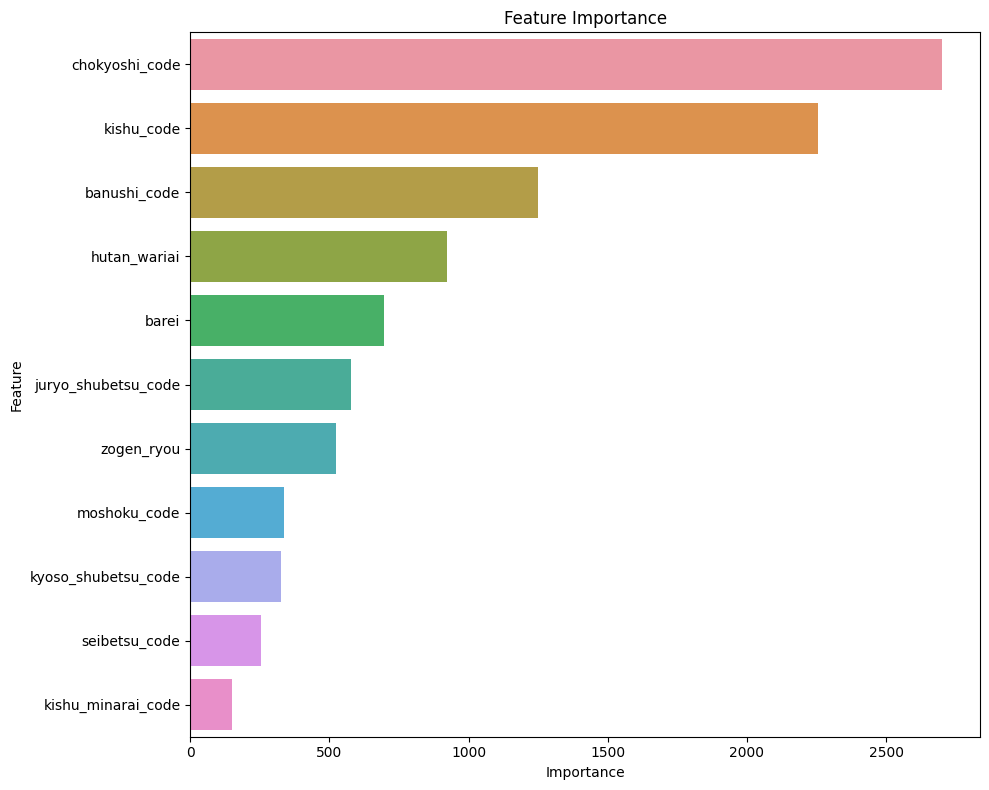

In [24]:
# models[0]'s feature importances
feature_importance = models[0].feature_importances_

# Convert feature names and importances to DataFrame
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
})

# Sort by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# モデル保存

In [25]:
# 学習
full_train_dataset = lgb.Dataset(merged_df[features], label=merged_df[target])
full_model = lgb.train(best_params, full_train_dataset, num_boost_round=500, verbose_eval=100)  # ここではvalid_setsやearly_stopping_roundsは使用しない

# モデルを保存
# model_save_path = '../app/models/model.pkl'
model_save_path = './bestmodels/lightgbmranker.pkl'
with open(model_save_path, 'wb') as f:
    pickle.dump(full_model, f)

print(f"Model saved to {model_save_path}")

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1172
[LightGBM] [Info] Number of data points in the train set: 2017402, number of used features: 11
[LightGBM] [Info] Start training from score 5.554518
Model saved to ./bestmodels/lightgbmranker.pkl


In [26]:
results_2020

group
2020-1001-30-1     False
2020-1001-30-10    False
2020-1001-30-11    False
2020-1001-30-12    False
2020-1001-30-2      True
                   ...  
2020-930-50-5       True
2020-930-50-6      False
2020-930-50-7      False
2020-930-50-8       True
2020-930-50-9       True
Length: 15067, dtype: bool

In [27]:
successful_groups_2020

Index(['2020-1001-30-2', '2020-1001-30-4', '2020-1001-30-7', '2020-1001-30-9',
       '2020-1001-43-5', '2020-1001-48-10', '2020-1001-48-3', '2020-1001-48-4',
       '2020-1001-48-5', '2020-1001-48-7',
       ...
       '2020-930-43-4', '2020-930-43-7', '2020-930-43-8', '2020-930-48-1',
       '2020-930-48-11', '2020-930-48-12', '2020-930-50-4', '2020-930-50-5',
       '2020-930-50-8', '2020-930-50-9'],
      dtype='object', name='group', length=4076)